### Main Project 1 script

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import fetch_20newsgroups

np.random.seed(42)
random.seed(42)

In [2]:
########################################################################################################################
## Custom Transformers for Grid Search

from sklearn.datasets import fetch_20newsgroups
from sklearn.base import BaseEstimator, TransformerMixin
import re
# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')


class Importer(BaseEstimator, TransformerMixin):

    def __init__(self, remove=None):
        self.remove = remove

    def transform(self, raw_documents, *_):
        if self.remove is not None:
            if 'headers' in self.remove:
                raw_documents = [self.strip_newsgroup_header(text) for text in raw_documents]
            if 'footers' in self.remove:
                raw_documents = [self.strip_newsgroup_footer(text) for text in raw_documents]

        return raw_documents

    def fit(self, *_):
        return self

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_header(text):
        """
        Given text in "news" format, strip the headers, by removing everything
        before the first blank line.

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        _before, _blankline, after = text.partition('\n\n')
        return after

    _QUOTE_RE = re.compile(r'(writes in|writes:|wrote:|says:|said:'
                           r'|^In article|^Quoted from|^\||^>)')

    ## Taken from twenty_newsgroups.py
    @staticmethod
    def strip_newsgroup_footer(text):
        """
        Given text in "news" format, attempt to remove a signature block.

        As a rough heuristic, we assume that signatures are set apart by either
        a blank line or a line made of hyphens, and that it is the last such line
        in the file (disregarding blank lines at the end).

        Parameters
        ----------
        text : string
            The text from which to remove the signature block.
        """
        lines = text.strip().split('\n')
        for line_num in range(len(lines) - 1, -1, -1):
            line = lines[line_num]
            if line.strip().strip('-') == '':
                break

        if line_num > 0:
            return '\n'.join(lines[:line_num])
        else:
            return text

In [3]:
########################################################################################################################
# Lemmatization functions used by CountVectorizer

# The lemmatizer is actually pretty complicated, it needs Parts of Speech (POS) tags
import nltk
from nltk import pos_tag
# nltk.download('punkt')#, if you need "tokenizers/punkt/english.pickle", choose it
# nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import CountVectorizer
analyzer = CountVectorizer().build_analyzer()

def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN': 'n', 'JJ': 'a',
                  'VB': 'v', 'RB': 'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

wnl = nltk.wordnet.WordNetLemmatizer()
def lemmatize_sent(list_word):
    # Text input is string, returns array of lowercased strings(words).
    return [wnl.lemmatize(word.lower(), pos=penn2morphy(tag)) 
            for word, tag in pos_tag(list_word)]

def isfloat(string):
    try:
        float(string)
        return True
    except:
        return False

def stem_rmv_punc(doc):
    return (word for word in lemmatize_sent(analyzer(doc)) if not isfloat(word))

In [4]:
# categories = ['comp.graphics', 'comp.os.ms-windows.misc',
#               'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
#               'rec.autos', 'rec.motorcycles',
#               'rec.sport.baseball', 'rec.sport.hockey']
# train_dataset = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
# test_dataset = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

#### Question 1

/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')
/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3221: MatplotlibDeprecationWarning: 
The `xmax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `right` instead.
  alternative='`right`', obj_type='argument')


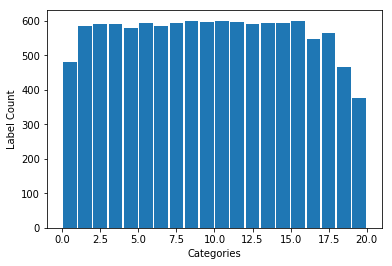

In [5]:
# Fetch all 20 news groups categories and plot a histogram of the training documents.

newsgroups_train = fetch_20newsgroups(subset='train', shuffle=True, random_state=42)
x = range(-1,23)
plt.hist(newsgroups_train.target, x, rwidth=0.9)
plt.xlabel('Categories')
plt.ylabel('Label Count')
plt.xlim(xmin=-1, xmax = 21)
plt.savefig('20-groups.eps', format='eps', dpi=100)
plt.show()

#### Question 2

In [22]:
########################################################################################################################
# Fetching 20NewsGroups dataset

categories = ['comp.graphics', 'comp.os.ms-windows.misc',
              'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware',
              'rec.autos', 'rec.motorcycles',
              'rec.sport.baseball', 'rec.sport.hockey']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

# Change labels into binary based on two well separated classes: Computer (labels 0-3) and Recreational (labels 4-7).
twenty_train_binary_labels = np.zeros(len(twenty_train.target))
for k in range(len(twenty_train.target)):
    if twenty_train.target[k] >= 4:
        twenty_train_binary_labels[k] = 2
twenty_test_binary_labels = np.zeros(len(twenty_test.target))
for k in range(len(twenty_test.target)):
    if twenty_test.target[k] >= 4:
        twenty_test_binary_labels[k] = 2
class_names = ['Computer Technology', 'Recreational Activity']

In [23]:
########################################################################################################################
# Push lemmatized documents through CountVectorizer

count_vect = CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')

# do for training
X_lemmatized_train_counts = count_vect.fit_transform(twenty_train.data)

# do for testing
X_lemmatized_test_counts = count_vect.transform(twenty_test.data)

In [24]:
########################################################################################################################
# Report shapes of TF-IDF matrices

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()

# do for training
X_lemmatized_train_tfidf = tfidf_transformer.fit_transform(X_lemmatized_train_counts)
print(X_lemmatized_train_tfidf.shape)

# do for testing
X_lemmatized_test_tfidf = tfidf_transformer.transform(X_lemmatized_test_counts)
print(X_lemmatized_test_tfidf.shape)

(4732, 16593)
(3150, 16593)


#### Question 3

In [25]:
# Perform LSI using the truncated SVD

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
X_lsi_train_reduced = svd.fit_transform(X_lemmatized_train_tfidf)
Y_lsi_train_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

X_lsi_test_reduced = svd.transform(X_lemmatized_test_tfidf)
Y_lsi_test_reduced = svd.components_
print(X_lsi_train_reduced.shape)
print(svd.components_.shape)

(4732, 50)
(50, 16593)
(4732, 50)
(50, 16593)


In [26]:
# Perform NMF

from sklearn.decomposition import NMF

model = NMF(n_components=50, init='random', random_state=42)
W_nmf_train_reduced = model.fit_transform(X_lemmatized_train_tfidf)
H_nmf_train_reduced = model.components_

print(W_nmf_train_reduced.shape)
print(H_nmf_train_reduced.shape)

W_nmf_test_reduced = model.transform(X_lemmatized_test_tfidf)
H_nmf_test_reduced = model.components_

(4732, 50)
(50, 16593)


In [27]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(W_nmf_train_reduced, H_nmf_train_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_train_tfidf - np.matmul(X_lsi_train_reduced, Y_lsi_train_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  3938.9375038396647
LSI:  3895.3842712014966


In [28]:
# Compare LSI and NMF

nmf_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(W_nmf_test_reduced, H_nmf_test_reduced), 'fro')**2
lsi_val = np.linalg.norm(X_lemmatized_test_tfidf - np.matmul(X_lsi_test_reduced, Y_lsi_test_reduced), 'fro')**2

print('NMF: ', nmf_val)
print('LSI: ', lsi_val)

NMF:  2687.499548403158
LSI:  2676.461431710637


##### Aside: Define function to nicely plot the confusion matrix

In [33]:
# Taken from scikit-learn website: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


## Question 4

In [34]:
# Training 2 linear SVMs

from sklearn.svm import LinearSVC

# hard margin
gamma_1 = 1000
clf_svc_1 = LinearSVC(C=gamma_1,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_1 = clf_svc_1.predict(X_lsi_test_reduced)

# using max_iter=100000 because otherwise the hard margin classifier does not converge

#soft margin
gamma_2 = 0.0001
clf_svc_2 = LinearSVC(C=gamma_2,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_2 = clf_svc_2.predict(X_lsi_test_reduced)

In [43]:
np.shape(X_lsi_test_reduced)

(3150, 50)

In [38]:
clf_svc_2.predict(X_lsi_test_reduced[1:20])

array([2., 2., 2., 2., 2., 0., 2., 2., 0., 0., 0., 2., 2., 2., 2., 2., 2.,
       2., 2.])

In [42]:
predicted_svc_1[0:10]

array([0., 0., 0., 0., 0., 0., 0., 2., 2., 0.])

Confusion matrix, without normalization
[[1503   57]
 [  31 1559]]


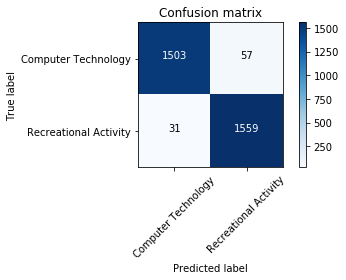

Normalized confusion matrix
[[0.96346154 0.03653846]
 [0.01949686 0.98050314]]


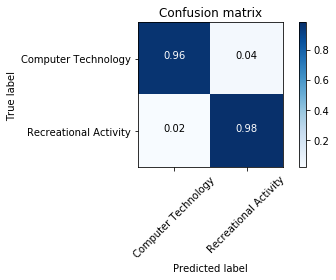

Accuracy for linear SVM hard margin:  0.9720634920634921


ValueError: pos_label=1 is not a valid label: array([0., 2.])

In [32]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the hard margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM hard margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names)
plt.savefig('svm-hard-conf.eps', format='eps', dpi=100)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_1), classes=class_names, normalize=True)
plt.show()


# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM hard margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_1))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM hard margin: ', precision_score(twenty_test_binary_labels, predicted_svc_1))
print('Recall score for linear SVM hard margin: ', recall_score(twenty_test_binary_labels, predicted_svc_1))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM hard margin:', f1_score(twenty_test_binary_labels, predicted_svc_1))

In [ ]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the soft margin

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for linear SVM soft margin: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_2))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_2), classes=class_names)
plt.savefig('svm-soft-conf.eps', format='eps', dpi=100)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_2), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for linear SVM soft margin: ', accuracy_score(twenty_test_binary_labels, predicted_svc_2))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for linear SVM soft margin: ', precision_score(twenty_test_binary_labels, predicted_svc_2))
print('Recall score for linear SVM soft margin: ', recall_score(twenty_test_binary_labels, predicted_svc_2))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for linear SVM soft margin:', f1_score(twenty_test_binary_labels, predicted_svc_2))

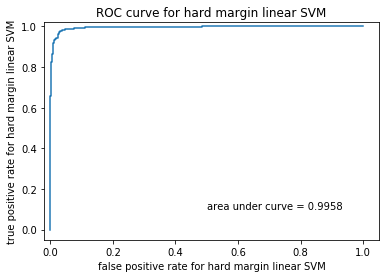

In [17]:
# ROC curve for hard margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_1 = clf_svc_1.decision_function(X_lsi_test_reduced)
fpr_svc_1, tpr_svc_1, thresholds_svc_1 = roc_curve(twenty_test_binary_labels, score_svc_1)

plt.figure()
plt.plot(fpr_svc_1, tpr_svc_1)
plt.title('ROC curve for hard margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_1))
plt.xlabel('false positive rate for hard margin linear SVM')
plt.ylabel('true positive rate for hard margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-hard-roc.eps', format='eps', dpi=100)
plt.show()

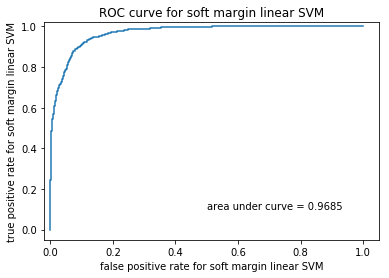

In [18]:
# ROC curve for soft margin SVM

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_2 = clf_svc_2.decision_function(X_lsi_test_reduced)
fpr_svc_2, tpr_svc_2, thresholds_svc_2 = roc_curve(twenty_test_binary_labels, score_svc_2)

plt.figure()
plt.plot(fpr_svc_2, tpr_svc_2)
plt.title('ROC curve for soft margin linear SVM')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_2))
plt.xlabel('false positive rate for soft margin linear SVM')
plt.ylabel('true positive rate for soft margin linear SVM')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-soft-roc.eps', format='eps', dpi=100)
plt.show()

 **Hard Margin SVM is better because accuracy for hard margin is 97% whereas it is 66% for soft margin. Also, F1 score of hard margin linear SVM is better**

In [19]:
# Cross validation to choose best gamma for the Linear SVM
import statistics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

# Reference: https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html

# Set the parameters to be determined by cross-validation
tuned_parameters = {'C': [0.001, 0.01, 0.1 , 1, 10, 100, 1000]}

# We are using the F1 score to determine the best value of gamma (C) for the linear SVM classifier

clf_svc_cv = GridSearchCV(SVC(kernel='linear'), tuned_parameters, cv=5, scoring= 'accuracy')
clf_svc_cv.fit(X_lsi_train_reduced, twenty_train_binary_labels)

print("Grid search scores on the basis of mean validation accuracy: ")
print()
means = clf_svc_cv.cv_results_['mean_test_score']
stds = clf_svc_cv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf_svc_cv.cv_results_['params']):
    print("%0.6f (+/-%0.06f) for %r"
          % (mean, std * 2, params))
print()

print("Optimal value of C: ")
print()
print(clf_svc_cv.best_params_)
print()


Grid search scores on the basis of mean validation accuracy: 

0.505 (+/-0.000) for {'C': 0.001}
0.506 (+/-0.002) for {'C': 0.01}
0.965 (+/-0.012) for {'C': 0.1}
0.973 (+/-0.013) for {'C': 1}
0.976 (+/-0.009) for {'C': 10}
0.974 (+/-0.009) for {'C': 100}
0.975 (+/-0.008) for {'C': 1000}

Optimal value of C: 

{'C': 10}



**Training the best SVM classifier with C=10**

In [20]:
#for the best linear SVM, we set the value of C to 10
gamma_best = 10 
clf_svc_best = LinearSVC(C=gamma_best,max_iter=100000).fit(X_lsi_train_reduced, twenty_train_binary_labels)
predicted_svc_best = clf_svc_best.predict(X_lsi_test_reduced)

**Plotting the ROC curve and report the confusion matrix and calculate the
accuracy, recall precision and F-1 score of this best SVM**

Confusion matrix, without normalization
[[1499   61]
 [  31 1559]]


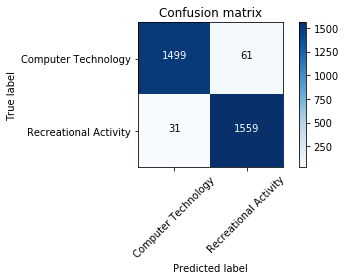

Normalized confusion matrix
[[0.96089744 0.03910256]
 [0.01949686 0.98050314]]


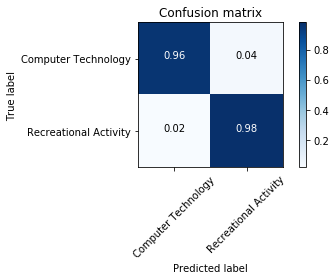

Accuracy for the best linear SVM classifier:  0.9707936507936508
Precision score for the best linear SVM classifier:  0.9623456790123457
Recall score for the best linear SVM classifier:  0.980503144654088
F-1 score for the best linear SVM classifier: 0.9713395638629283


In [21]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores for the best linear SVM classifier

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix for the best linear SVM classifier: \n', confusion_matrix(twenty_test_binary_labels, predicted_svc_1))

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_best), classes=class_names)
plt.savefig('svm-best-conf.eps', format='eps', dpi=100)
plt.show()

plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted_svc_best), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy for the best linear SVM classifier: ', accuracy_score(twenty_test_binary_labels, predicted_svc_best))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score for the best linear SVM classifier: ', precision_score(twenty_test_binary_labels, predicted_svc_best))
print('Recall score for the best linear SVM classifier: ', recall_score(twenty_test_binary_labels, predicted_svc_best))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score for the best linear SVM classifier:', f1_score(twenty_test_binary_labels, predicted_svc_best))

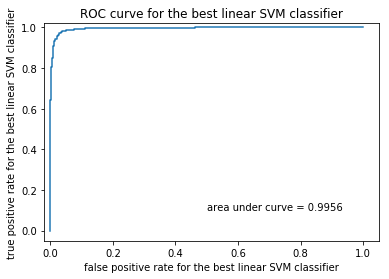

In [22]:
# ROC curve for the best linear SVM classifier

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score_svc_best = clf_svc_best.decision_function(X_lsi_test_reduced)
fpr_svc_best, tpr_svc_best, thresholds_svc_best = roc_curve(twenty_test_binary_labels, score_svc_best)

plt.figure()
plt.plot(fpr_svc_best, tpr_svc_best)
plt.title('ROC curve for the best linear SVM classifier')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_svc_best))
plt.xlabel('false positive rate for the best linear SVM classifier')
plt.ylabel('true positive rate for the best linear SVM classifier')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.savefig('svm-best-roc.eps', format='eps', dpi=100)
plt.show()

#### Question 5

In [23]:
# Train an unregularized logistic regression classifier.

from sklearn.linear_model import LogisticRegression

# To be unregularized, we make the inverse of the regularization strength C 
# to be large to approximate an unregularized classifier.
clf = LogisticRegression(random_state=42, C=500, max_iter=100, solver='lbfgs').fit(X_lsi_train_reduced, twenty_train_binary_labels)

# score = clf.decision_function(X_lsi_test_reduced)
predicted = clf.predict(X_lsi_test_reduced)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


Confusion matrix, without normalization
[[1499   61]
 [  30 1560]]


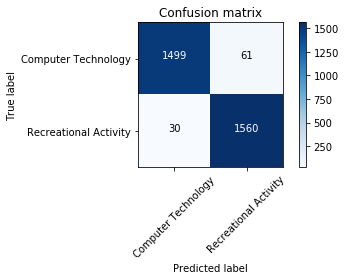

Normalized confusion matrix
[[0.96089744 0.03910256]
 [0.01886792 0.98113208]]


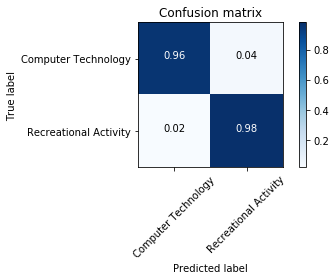

Accuracy:  0.9711111111111111
Precision score:  0.9623689080814312
Recall score:  0.9811320754716981
F-1 score: 0.9716599190283399


In [24]:
# Find confusion matrix, accuracy, precision-recall, and F-1 scores

# Confusion matrix
from sklearn.metrics import confusion_matrix

# print('Confusion matrix: \n', confusion_matrix(twenty_test_binary_labels, predicted))
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
plt.show()

# Accuracy
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(twenty_test_binary_labels, predicted))

# Average precision-recall score
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# print('Average precision-recall score:', average_precision_score(twenty_test.target, predicted))
print('Precision score: ', precision_score(twenty_test_binary_labels, predicted))
print('Recall score: ', recall_score(twenty_test_binary_labels, predicted))

# F-1 score
from sklearn.metrics import f1_score

print('F-1 score:', f1_score(twenty_test_binary_labels, predicted))

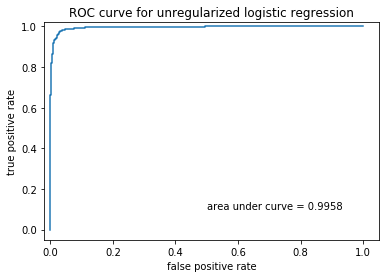

In [25]:
# ROC curve

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

score = clf.decision_function(X_lsi_test_reduced)
fpr, tpr, thresholds = roc_curve(twenty_test_binary_labels, score)

plt.figure()
plt.plot(fpr, tpr)
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score))
plt.title('ROC curve for unregularized logistic regression')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.02)
plt.ylim(top=1.02)
plt.show()

Optimal regularization strength for L1 Regulation:  [0.1]
Accuracy with L1 Regulation for L1 Regulation:  0.9707936507936508
Average precision-recall score for L1 Regulation: 0.9526115713987328
Precision score for L1 Regulation:  0.9606396063960639
Recall score for L1 Regulation:  0.9823899371069182
F-1 score for L1 Regulation: 0.9713930348258706


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


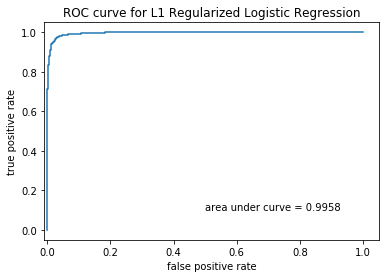


Optimal regularization strength for L2 regulation:  [0.01]
Accuracy with L2 Regulation:  0.9701587301587301
Average precision-recall score for L2 Regulation: 0.9517210668063554
Precision score for L2 Regulation:  0.9600246002460024
Recall score for L2 Regulation:  0.9817610062893082
F-1 score for L2 Regulation: 0.9707711442786069


C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\linear_model\logistic.py:1917: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


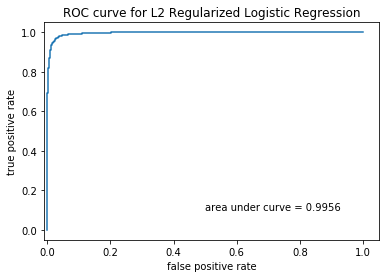

In [26]:
from sklearn.linear_model import LogisticRegressionCV

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

# Define regularization strength values here
REG_STRENGTH_OPTIONS = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# Determine regulation strength for L1 regulation
clf_L1 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l1', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
l1_reg_strength = 1/clf_L1.C_ # Regulization strength is inverse of optimal Cs
predicted_L1 = clf_L1.predict(X_test)

# Display L1 Stats
print('Optimal regularization strength for L1 Regulation: ', l1_reg_strength)
print('Accuracy with L1 Regulation for L1 Regulation: ', clf_L1.score(X_test, y_test))
print('Average precision-recall score for L1 Regulation:', average_precision_score(y_test, predicted_L1))
print('Precision score for L1 Regulation: ', precision_score(y_test, predicted_L1))
print('Recall score for L1 Regulation: ', recall_score(y_test, predicted_L1))
print('F-1 score for L1 Regulation:', f1_score(y_test, predicted_L1))

# L1 ROC Curve
score_L1 = clf_L1.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L1)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L1 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_L1))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

# Determine regulation strength for L2 regulation
clf_L2 = LogisticRegressionCV(random_state=42, Cs=REG_STRENGTH_OPTIONS, cv=5, penalty='l2', scoring='accuracy', solver = 'liblinear').fit(X_train, y_train)
L2_reg_strength = 1/clf_L2.C_ # Regulization strength is inverse of optimal Cs
predicted_L2 = clf_L2.predict(X_test)

# Display L2 Stats
print('\nOptimal regularization strength for L2 regulation: ', L2_reg_strength)
print('Accuracy with L2 Regulation: ', clf_L2.score(X_test, y_test))
print('Average precision-recall score for L2 Regulation:', average_precision_score(y_test, predicted_L2))
print('Precision score for L2 Regulation: ', precision_score(y_test, predicted_L2))
print('Recall score for L2 Regulation: ', recall_score(y_test, predicted_L2))
print('F-1 score for L2 Regulation:', f1_score(y_test, predicted_L2))

# L2 ROC Curve
score_L2 = clf_L2.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, score_L2)

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for L2 Regularized Logistic Regression')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, score_L2))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

#### Question 6

In [27]:
########################################################################################################################
# Train a Naive Bayes Gaussian classifier on the reduced TFIDF training set from problem 3

from sklearn.naive_bayes import GaussianNB

Confusion matrix, without normalization
[[1295  265]
 [  44 1546]]


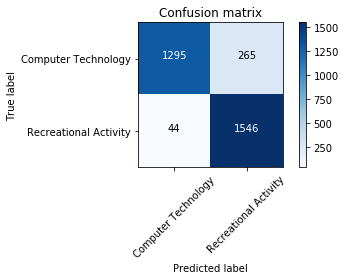

Normalized confusion matrix
[[0.83012821 0.16987179]
 [0.02767296 0.97232704]]


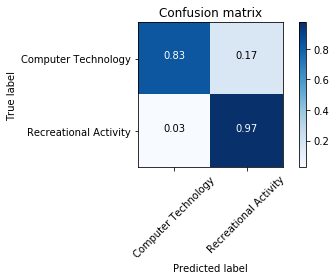

Accuracy for Gaussian NB from LSI:  0.9019047619047619
Average precision-recall score for Gaussian NB from LSI: 0.844016630590503
Precision score for Gaussian NB from LSI:  0.853672004417449
Recall score for Gaussian NB from LSI:  0.9723270440251572
F-1 score for Gaussian NB from LSI: 0.909144369303146


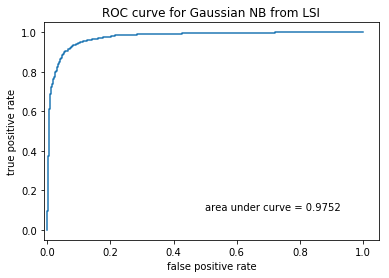

In [28]:
########################################################################################################################
# Generate stats for GaussianNB using LSI for reduction

# Define training and testing data sets
X_train = X_lsi_train_reduced
y_train = twenty_train_binary_labels

X_test = X_lsi_test_reduced
y_test = twenty_test_binary_labels

clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

predicted = clf.predict(X_test)

# Confusion Matrix
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
plt.show()
plt.figure()
plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
plt.show()

# Display GNB Stats
print('Accuracy for Gaussian NB from LSI: ', clf.score(X_test, y_test))
print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted))

# GNB ROC Curve
prob_score = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

plt.figure()
plt.plot(fpr, tpr)
plt.title('ROC curve for Gaussian NB from LSI')
plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, prob_score[:, 1]))
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(left=-0.01)
plt.show()

In [29]:
########################################################################################################################
# Generate stats for GaussianNB using NMF for reduction

# # Define training and testing data sets
# X_train = W_nmf_train_reduced
# y_train = twenty_train_binary_labels

# X_test = W_nmf_test_reduced
# y_test = twenty_test_binary_labels

# clf = GaussianNB().fit(X_train, twenty_train_binary_labels)

# predicted = clf.predict(X_test)

# plt.figure()
# plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names)
# plt.show()
# plt.figure()
# plot_confusion_matrix(confusion_matrix(twenty_test_binary_labels, predicted), classes=class_names, normalize=True)
# plt.show()

# # Display GNB Stats
# print('Accuracy for Gaussian NB for NMF: ', clf.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB for NMF:', average_precision_score(y_test, predicted))
# print('Precision score for Gaussian NB for NMF: ', precision_score(y_test, predicted))
# print('Recall score for Gaussian NB for NMF: ', recall_score(y_test, predicted))
# print('F-1 score for Gaussian NB for NMF:', f1_score(y_test, predicted))

# # GNB ROC Curve
# prob_score = clf.predict_proba(X_test)
# fpr, tpr, thresholds = roc_curve(y_test, prob_score[:, 1])

# plt.figure()
# plt.plot(fpr, tpr)
# plt.title('ROC curve for Gaussian NB from NMF')
# plt.text(0.5, 0.1, 'area under curve = %0.4f' % roc_auc_score(twenty_test_binary_labels, prob_score[:, 1]))
# plt.xlabel('false positive rate')
# plt.ylabel('true positive rate')
# plt.xlim(left=-0.01)
# plt.show()

#### Question 7

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=1, stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD()),
    ('clf', GaussianNB()),
],
memory=memory
)

param_grid = [
    {
        'import__remove': [None, ['headers', 'footers']],
        'vect__min_df': [3, 5],
        'vect__analyzer': ['word', stem_rmv_punc],
        'reduce_dim': [TruncatedSVD(random_state=42, n_components=50), NMF(random_state=42, n_components=50)],
        'clf': [LinearSVC(C=10,max_iter=100000),
               LogisticRegression(random_state=42, C=0.1, penalty='l1', solver='liblinear'),
               LogisticRegression(random_state=42, C=0.01, penalty='l2', solver='liblinear'),
               GaussianNB()]
    }
]

grid = GridSearchCV(pipeline, cv=5, n_jobs=1, param_grid=param_grid, scoring='accuracy')
grid.fit(twenty_train.data, twenty_train_binary_labels)
rmtree(cachedir)

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:16: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpmumwibjv'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpmumwibjv'" instead.
  app.launch_new_instance()


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=None), [ 'From: rschmitt@shearson.com (Robert Schmitt)\n'
  'Subject: Re: Please Recommend 3D Graphics Library F\n'
  'Reply-To: rschmitt@shearson.com\n'
  'Organization: Lehman Brothers, Inc.\n'
  'Lines: 9\n'
  '\n'
  'What hardware do plan to run on?  Workstation or PC?  Cost level?\n'
  'Run-time licensing needs?\n'
  '\n'
  'Bob\n'
  '------------------------------------------------------------------\n'
  'Robert A. Schmitt | Applied Derivatives Technology | Lehman Brothers\n'
  'rschmitt@shearson.com\n'
  '\n'
  '\n',
  'From: mori@volga.mfd.cs.fujitsu.co.jp (Tsuyoshi Mori)\n'
  'Subject: I want use DeskJet on System7\n'
  'Organization: FUJITSU.Ltd., Kawasaki, Japan.\n'
  'Lines: 15\n'
  'Di..., 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.6s, 0.0min
______

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17574 sparse matrix of type '<class 'numpy.int64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17574 sparse matrix of type '<class 'numpy.float64'>'
	with 329115 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.28s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17232 sparse matrix of type '<class 'numpy.int64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17232 sparse matrix of type '<class 'numpy.float64'>'
	with 324344 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x17671 sparse matrix of type '<class 'numpy.int64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x17671 sparse matrix of type '<class 'numpy.float64'>'
	with 328511 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.45s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x17321 sparse matrix of type '<class 'numpy.int64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x17321 sparse matrix of type '<class 'numpy.float64'>'
	with 327753 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.33s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.8s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x17420 sparse matrix of type '<class 'numpy.int64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x17420 sparse matrix of type '<class 'numpy.float64'>'
	with 328453 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11007 sparse matrix of type '<class 'numpy.int64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11007 sparse matrix of type '<class 'numpy.float64'>'
	with 306922 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.19s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.5s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x10930 sparse matrix of type '<class 'numpy.int64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x10930 sparse matrix of type '<class 'numpy.float64'>'
	with 303063 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.32s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11017 sparse matrix of type '<class 'numpy.int64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11017 sparse matrix of type '<class 'numpy.float64'>'
	with 306084 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11109 sparse matrix of type '<class 'numpy.int64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x11109 sparse matrix of type '<class 'numpy.float64'>'
	with 306687 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.31s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.6s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x11048 sparse matrix of type '<class 'numpy.int64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x11048 sparse matrix of type '<class 'numpy.float64'>'
	with 306977 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.94s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 87.7s, 1.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14466 sparse matrix of type '<class 'numpy.int64'>'
	with 430851 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14466 sparse matrix of type '<class 'numpy.float64'>'
	with 430851 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.76s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 85.5s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14050 sparse matrix of type '<class 'numpy.int64'>'
	with 424311 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14050 sparse matrix of type '<class 'numpy.float64'>'
	with 424311 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.83s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 86.8s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14551 sparse matrix of type '<class 'numpy.int64'>'
	with 429942 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14551 sparse matrix of type '<class 'numpy.float64'>'
	with 429942 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 87.1s, 1.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14142 sparse matrix of type '<class 'numpy.int64'>'
	with 429441 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14142 sparse matrix of type '<class 'numpy.float64'>'
	with 429441 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.78s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 84.2s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14260 sparse matrix of type '<class 'numpy.int64'>'
	with 429727 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14260 sparse matrix of type '<class 'numpy.float64'>'
	with 429727 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 87.4s, 1.5min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9149 sparse matrix of type '<class 'numpy.int64'>'
	with 412916 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9149 sparse matrix of type '<class 'numpy.float64'>'
	with 412916 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 85.2s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9048 sparse matrix of type '<class 'numpy.int64'>'
	with 407411 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9048 sparse matrix of type '<class 'numpy.float64'>'
	with 407411 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.05s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 86.8s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9135 sparse matrix of type '<class 'numpy.int64'>'
	with 411705 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9135 sparse matrix of type '<class 'numpy.float64'>'
	with 411705 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.90s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 86.6s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9225 sparse matrix of type '<class 'numpy.int64'>'
	with 412756 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9225 sparse matrix of type '<class 'numpy.float64'>'
	with 412756 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.02s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 84.1s, 1.4min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9175 sparse matrix of type '<class 'numpy.int64'>'
	with 412538 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9175 sparse matrix of type '<class 'numpy.float64'>'
	with 412538 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 5.8s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\4bce4fe267c6491d9f0e5346c9395f1c
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\85956c7ddaa7a8e7153a739701fb1625
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...

___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\676eb9d9b48d56e2ac2e8e239b2fe7e2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<3785x14551 sparse matrix of type '<class 'numpy.float64'>'
	with 429942 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________fit_transform_one - 14.1s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwib

________________________________________________fit_transform_one - 7.5s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\602e74b2ca22e8d369713a941eab2706
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\68f9bbc69bc613c9375d0be9071b5923
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.79s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14648 sparse matrix of type '<class 'numpy.int64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14648 sparse matrix of type '<class 'numpy.float64'>'
	with 241382 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.88s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.2s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14377 sparse matrix of type '<class 'numpy.int64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14377 sparse matrix of type '<class 'numpy.float64'>'
	with 237491 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.85s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x14870 sparse matrix of type '<class 'numpy.int64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x14870 sparse matrix of type '<class 'numpy.float64'>'
	with 242060 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.82s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x14540 sparse matrix of type '<class 'numpy.int64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x14540 sparse matrix of type '<class 'numpy.float64'>'
	with 241095 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.84s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.3s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x14676 sparse matrix of type '<class 'numpy.int64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x14676 sparse matrix of type '<class 'numpy.float64'>'
	with 241604 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.96s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9052 sparse matrix of type '<class 'numpy.int64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9052 sparse matrix of type '<class 'numpy.float64'>'
	with 222536 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.80s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x8964 sparse matrix of type '<class 'numpy.int64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x8964 sparse matrix of type '<class 'numpy.float64'>'
	with 219298 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.97s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x9146 sparse matrix of type '<class 'numpy.int64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x9146 sparse matrix of type '<class 'numpy.float64'>'
	with 222772 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x9181 sparse matrix of type '<class 'numpy.int64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x9181 sparse matrix of type '<class 'numpy.float64'>'
	with 222996 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.86s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 2.1s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x9172 sparse matrix of type '<class 'numpy.int64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x9172 sparse matrix of type '<class 'numpy.float64'>'
	with 223059 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.49s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.0s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12006 sparse matrix of type '<class 'numpy.int64'>'
	with 338497 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12006 sparse matrix of type '<class 'numpy.float64'>'
	with 338497 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.15s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 68.2s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x11620 sparse matrix of type '<class 'numpy.int64'>'
	with 333078 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x11620 sparse matrix of type '<class 'numpy.float64'>'
	with 333078 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.53s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.8s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x12186 sparse matrix of type '<class 'numpy.int64'>'
	with 338723 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x12186 sparse matrix of type '<class 'numpy.float64'>'
	with 338723 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.0s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x11807 sparse matrix of type '<class 'numpy.int64'>'
	with 338115 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x11807 sparse matrix of type '<class 'numpy.float64'>'
	with 338115 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 2.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 67.5s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x11962 sparse matrix of type '<class 'numpy.int64'>'
	with 338151 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x11962 sparse matrix of type '<class 'numpy.float64'>'
	with 338151 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_____________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.64s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.1s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7475 sparse matrix of type '<class 'numpy.int64'>'
	with 323271 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7475 sparse matrix of type '<class 'numpy.float64'>'
	with 323271 stored elements in Compressed Sparse Row format>, 
array([0., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.65s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 68.3s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7359 sparse matrix of type '<class 'numpy.int64'>'
	with 318767 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7359 sparse matrix of type '<class 'numpy.float64'>'
	with 318767 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.55s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 70.4s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3785x7531 sparse matrix of type '<class 'numpy.int64'>'
	with 323035 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3785x7531 sparse matrix of type '<class 'numpy.float64'>'
	with 323035 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.68s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 69.7s, 1.2min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3786x7560 sparse matrix of type '<class 'numpy.int64'>'
	with 323758 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3786x7560 sparse matrix of type '<class 'numpy.float64'>'
	with 323758 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.71s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


_______________________________________________fit_transform_one - 67.4s, 1.1min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <3787x7613 sparse matrix of type '<class 'numpy.int64'>'
	with 323460 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<3787x7613 sparse matrix of type '<class 'numpy.float64'>'
	with 323460 stored elements in Compressed Sparse Row format>, 
array([1., ..., 1.]), None)
_______________________________________________

________________________________________________fit_transform_one - 5.2s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8cb8181463b9f42cbaaccf832a3b6c0e
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c17e99ebaab4286fc5d8d919782040f1
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...

___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8cb5fc3e493827a0cf09a017baa4b928
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<3785x12186 sparse matrix of type '<class 'numpy.float64'>'
	with 338723 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_______________________________________________fit_transform_one - 11.8s, 0.2min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwib

________________________________________________fit_transform_one - 6.7s, 0.1min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b1899b1103a9233ba71c31e568aa844d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a92f19de4dc145a099068efff9a30a54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ac9ec2dbbaee2a798c5a1dfb0a5f854f
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1ba87630837e13ff44fffc5cff860023
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a2d6f25d9d8ca7b0b9e4aef41b834a6f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\203f813f24af489330c776e2b90380a4
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c206e4da3126cdac6bbffddfa7d7f4b8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\dad06b38288a3810d9f142328bb3fe96
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\d92e9ca2ba55f9777244e9b3782e27ea
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b7d63142df94e915b61cc4ef73b4b229
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\f8d26acc8a9ec849e29ad83e62c26965
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\9f3cba3fd641575e3111d2e33284df85
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5864bf2227893af8a6ffcf4c8317e8dd
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\602e74b2ca22e8d369713a941eab2706
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\68f9bbc69bc613c9375d0be9071b5923
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\632d27408121bc1f8a7cc7667d139e10
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b00348d6389ef6510ad1c0c53508c8c8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b682fe9012f21c58d2e6568d8ea8a629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\558e6342fc75b3c0504489b6b321e42f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1cfa3905c92e9cc26a3388b24ab6bd54
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\6d475d8f3959d37394ab0b631386745e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\aada9ca7f6ef5c7565f2cc25d86c1539
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b801fd061788497bb826c0be99d60ba6
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\009f9afadbc6504efd1e6d611c4bfd59
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\fb1e9c9038f5c44ceaf65bd01f49c891
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\7349b79de8653e1aa80ee7ff08484198
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8c93d4f2e218763e622d53ab17f5f682
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ec5d0f9dabcd2605d6cd8664a317222c
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b1899b1103a9233ba71c31e568aa844d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a92f19de4dc145a099068efff9a30a54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8b98afeb9698dc55f3a1879c2e16a7f0
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ac9ec2dbbaee2a798c5a1dfb0a5f854f
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1ba87630837e13ff44fffc5cff860023
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a2d6f25d9d8ca7b0b9e4aef41b834a6f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\203f813f24af489330c776e2b90380a4
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c206e4da3126cdac6bbffddfa7d7f4b8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\dad06b38288a3810d9f142328bb3fe96
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\d92e9ca2ba55f9777244e9b3782e27ea
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b7d63142df94e915b61cc4ef73b4b229
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\f8d26acc8a9ec849e29ad83e62c26965
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\9f3cba3fd641575e3111d2e33284df85
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5864bf2227893af8a6ffcf4c8317e8dd
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\602e74b2ca22e8d369713a941eab2706
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\68f9bbc69bc613c9375d0be9071b5923
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\632d27408121bc1f8a7cc7667d139e10
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b00348d6389ef6510ad1c0c53508c8c8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b682fe9012f21c58d2e6568d8ea8a629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\558e6342fc75b3c0504489b6b321e42f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1cfa3905c92e9cc26a3388b24ab6bd54
___________________________________fit_transform_one cache loaded - 0.2s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\6d475d8f3959d37394ab0b631386745e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\aada9ca7f6ef5c7565f2cc25d86c1539
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b801fd061788497bb826c0be99d60ba6
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\009f9afadbc6504efd1e6d611c4bfd59
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\fb1e9c9038f5c44ceaf65bd01f49c891
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\7349b79de8653e1aa80ee7ff08484198
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8c93d4f2e218763e622d53ab17f5f682
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ec5d0f9dabcd2605d6cd8664a317222c
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b1899b1103a9233ba71c31e568aa844d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a92f19de4dc145a099068efff9a30a54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8b98afeb9698dc55f3a1879c2e16a7f0
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\02b290dccb3325f39b8f06db3c8a09fb
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ac9ec2dbbaee2a798c5a1dfb0a5f854f
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1ba87630837e13ff44fffc5cff860023
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a2d6f25d9d8ca7b0b9e4aef41b834a6f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\bc64d833e6b3db3c1a80e7ac2b1000e8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.1s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\203f813f24af489330c776e2b90380a4
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c206e4da3126cdac6bbffddfa7d7f4b8
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\dad06b38288a3810d9f142328bb3fe96
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\eed1352d6e39439e597884e7b3ac7430
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\d92e9ca2ba55f9777244e9b3782e27ea
___________________________________fit_transform_one cache loaded - 0.5s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b8e2d9bda415986896aba105967e4457
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.6s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b7d63142df94e915b61cc4ef73b4b229
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\499bec3abc0e0a7a4342c2112558a22b
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\f8d26acc8a9ec849e29ad83e62c26965
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\9f3cba3fd641575e3111d2e33284df85
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5864bf2227893af8a6ffcf4c8317e8dd
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\3aa0990cb487d8cb8e038672b786ccf4
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\602e74b2ca22e8d369713a941eab2706
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\68f9bbc69bc613c9375d0be9071b5923
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\632d27408121bc1f8a7cc7667d139e10
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\c4816fe37dde329cdbe8377bcb8ea012
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b00348d6389ef6510ad1c0c53508c8c8
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b682fe9012f21c58d2e6568d8ea8a629
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\558e6342fc75b3c0504489b6b321e42f
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\31ddf07b6aec35e6ff8b21c16365e5a0
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\1cfa3905c92e9cc26a3388b24ab6bd54
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\6d475d8f3959d37394ab0b631386745e
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\aada9ca7f6ef5c7565f2cc25d86c1539
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\14caaec420fd3a4a7ff5f5deac98e0c6
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b801fd061788497bb826c0be99d60ba6
___________________________________fit_transform_one cache loaded - 0.4s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\009f9afadbc6504efd1e6d611c4bfd59
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.5s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\fb1e9c9038f5c44ceaf65bd01f49c891
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\5cbb6aeea2c5f45286e965953e43e974
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\7349b79de8653e1aa80ee7ff08484198
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8c93d4f2e218763e622d53ab17f5f682
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\ec5d0f9dabcd2605d6cd8664a317222c
___________________________________fi

[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\76caf92797bd7ebe3b0b24c8f509b89d
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.0s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\b1899b1103a9233ba71c31e568aa844d
___________________________________fit_transform_one cache loaded - 0.3s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\a92f19de4dc145a099068efff9a30a54
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]0.4s, 0.0min    : Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmumwibjv\joblib\sklearn\pipeline\_fit_transform_one\8b98afeb9698dc55f3a1879c2e16a7f0
___________________________________fi

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 3.35s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


______________________________________________fit_transform_one - 110.7s, 1.8min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <4732x16595 sparse matrix of type '<class 'numpy.int64'>'
	with 541251 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<4732x16595 sparse matrix of type '<class 'numpy.float64'>'
	with 541251 stored elements in Compressed Sparse Row format>, 
array([1., ..., 0.]), None)
_____________________________________________

In [31]:
import pandas as pd
results = pd.DataFrame(grid.cv_results_)
results.to_csv('grid_search_results.csv')

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.wa

In [32]:
results = pd.read_csv('grid_search_results.csv')
results

,Unnamed: 0,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_clf,param_import__remove,param_reduce_dim,param_vect__analyzer,param_vect__min_df,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0,7.947792,0.236443,0.974218,0.978445,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",word,3,...,0.975713,0.976750,0.973573,0.979926,0.979894,0.978875,0.127328,0.007712,0.004084,0.001027
1,1,5.604999,0.233447,0.972527,0.977811,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",word,5,...,0.975713,0.976750,0.967230,0.978341,0.978836,0.978347,0.079371,0.009916,0.004374,0.000768
2,2,89.930409,21.218552,0.974852,0.978497,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",<function stem_rmv_punc at 0x000001DD34916268>,3,...,0.976769,0.978336,0.968288,0.980718,0.976720,0.978083,1.305357,1.105831,0.004456,0.001463
3,3,88.780939,21.235935,0.973795,0.978127,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"TruncatedSVD(algorithm='randomized', n_compone...",<function stem_rmv_punc at 0x000001DD34916268>,5,...,0.977825,0.978071,0.964059,0.979398,0.976720,0.978875,1.202266,1.103519,0.005241,0.001177
4,4,11.019164,0.306667,0.963440,0.960218,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",word,3,...,0.965153,0.960370,0.953488,0.960909,0.977778,0.959071,2.412776,0.008314,0.008078,0.001035
5,5,7.839156,0.282664,0.964708,0.962806,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",word,5,...,0.963041,0.961162,0.961945,0.960380,0.969312,0.963560,2.187280,0.010444,0.002706,0.001809
6,6,13.425837,21.229556,0.964708,0.964180,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",<function stem_rmv_punc at 0x000001DD34916268>,3,...,0.967265,0.963804,0.960888,0.962229,0.969312,0.964352,2.025559,1.111689,0.004088,0.002225
7,7,9.670569,21.238368,0.961116,0.965079,"LinearSVC(C=10, class_weight=None, dual=True, ...",NaN,"NMF(alpha=0.0, beta_loss='frobenius', init=Non...",<function stem_rmv_punc at 0x000001DD34916268>,5,...,0.963041,0.965918,0.959831,0.962493,0.964021,0.961975,1.312369,1.135826,0.002608,0.002405
8,8,6.780365,0.200063,0.972739,0.975909,"LinearSVC(C=10, class_weight=None, dual=True, ...","['headers', 'footers']","TruncatedSVD(algorithm='randomized', n_compone...",word,3,...,0.973601,0.974373,0.968288,0.977021,0.979894,0.976499,0.044140,0.010798,0.004964,0.001676
9,9,4.652216,0.193842,0.971893,0.975116,"LinearSVC(C=10, class_weight=None, dual=True, ...","['headers', 'footers']","TruncatedSVD(algorithm='randomized', n_compone...",word,5,...,0.971489,0.972787,0.968288,0.975700,0.976720,0.975970,0.095206,0.010152,0.003371,0.001599


#### Question 8

In [33]:
## Create new multiclass dataset

## Pulled from Question 1
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

X_train = twenty_train.data
y_train = twenty_train.target

X_test = twenty_test.data
y_test = twenty_test.target

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp9evgczon'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp9evgczon'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmplxxxlr8y'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmplxxxlr8y'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.23s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row forma

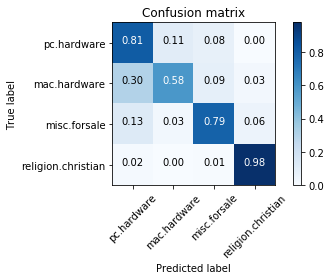

Accuracy for Multinomial NB from NMF:  0.792332268370607
Precision score for Multinomial NB from NMF:  0.8003665977557446
Recall score for Multinomial NB from NMF:  0.7906926496571148
F-1 score for Multinomial NB from NMF: 0.7884576782557926


In [34]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=42, n_components=50)),
    ('clf', MultinomialNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Multinomial NB from NMF: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Multinomial NB from NMF: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Multinomial NB from NMF: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Multinomial NB from NMF:', f1_score(y_test, predicted, average='macro'))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpqe_qy2pk'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpqe_qy2pk'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpd3i1os6u'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpd3i1os6u'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.08s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=42, tol=0.0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
_________________________

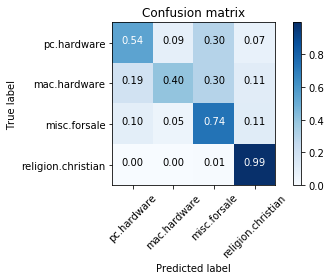

Accuracy for Gaussian NB from LSI:  0.6702875399361022
Precision score for Gaussian NB from LSI:  0.6796041532241356
Recall score for Gaussian NB from LSI:  0.6679221591999769
F-1 score for Gaussian NB from LSI: 0.6531172030402432


In [35]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', GaussianNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Gaussian NB from LSI: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from LSI: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Gaussian NB from LSI: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Gaussian NB from LSI:', f1_score(y_test, predicted, average='macro'))

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:18: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp2u9odiyi'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmp2u9odiyi'" instead.
C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpmvx_0hmi'", use "location='C:\\Users\\zharr\\AppData\\Local\\Temp\\tmpmvx_0hmi'" instead.


________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(Importer(remove=['headers', 'footers']), [ 'From: noye@midway.uchicago.edu (vera shanti noyes)\n'
  "Subject: Re: An agnostic's question\n"
  'Reply-To: noye@midway.uchicago.edu\n'
  'Organization: University of Chicago\n'
  'Lines: 23\n'
  '\n'
  'perhaps you can tell your friend that you feel pressured by his\n'
  "continual discussions of this topic -- surely he doesn't feel you\n"
  'should be _pressured_ into something you feel uncomfortable about\n'
  "(since christianity should be a choice one should make on one's own).\n"
  'please also realize that he is doing this out of friendship -- he\n'
  'probably feels you are missing out on something great, and wants to\n'
  'tell you about it.  but since you know where you can lea..., 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transf

C:\Users\zharr\AppData\Local\Programs\Python\Python35\lib\site-packages\sklearn\pipeline.py:230: UserWarning: Persisting input arguments took 1.20s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


________________________________________________fit_transform_one - 1.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(TfidfTransformer(norm='l2', smooth_idf=True, sublinear_tf=False, use_idf=True), <2352x5534 sparse matrix of type '<class 'numpy.int64'>'
	with 131795 stored elements in Compressed Sparse Row format>, 
array([3, ..., 1], dtype=int64), None)
________________________________________________fit_transform_one - 0.0s, 0.0min
________________________________________________________________________________
[Memory] Calling sklearn.pipeline._fit_transform_one...
_fit_transform_one(NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=42, shuffle=False, solver='cd', tol=0.0001,
  verbose=0), 
<2352x5534 sparse matrix of type '<class 'numpy.float64'>'
	with 131795 stored elements in Compressed Sparse Row forma

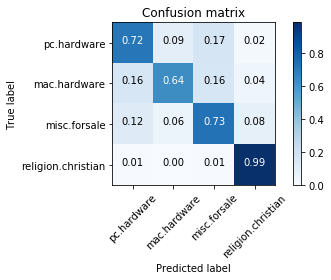

Accuracy for Gaussian NB from NMF:  0.7699680511182109
Precision score for Gaussian NB from NMF:  0.76929707673951
Recall score for Gaussian NB from NMF:  0.7684927225801239
F-1 score for Gaussian NB from NMF: 0.7653852416933962


In [36]:
## Naive Bayes Multiclass Classification

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.decomposition import TruncatedSVD, NMF

# used to cache results
from tempfile import mkdtemp
from shutil import rmtree
from sklearn.externals.joblib import Memory
# print(__doc__)
cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

cachedir = mkdtemp()
memory = Memory(cachedir=cachedir, verbose=10)

pipeline = Pipeline([
    ('import', Importer(remove=['headers', 'footers'])),
    ('vect', CountVectorizer(min_df=5, analyzer='word', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', NMF(random_state=42, n_components=50)),
    ('clf', GaussianNB()),
],
memory=memory
)

pipeline.fit(X_train, y_train)

predicted = pipeline.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted), classes=class_names, normalize=True)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display GNB Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for Gaussian NB from NMF: ', pipeline.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for Gaussian NB from NMF: ', precision_score(y_test, predicted, average='macro'))
print('Recall score for Gaussian NB from NMF: ', recall_score(y_test, predicted, average='macro'))
print('F-1 score for Gaussian NB from NMF:', f1_score(y_test, predicted, average='macro'))

**SVM 1v1 method:**

In [40]:
from sklearn.multiclass import OneVsOneClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

## Pulled from Question 1
categories = ['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'misc.forsale', 'soc.religion.christian']

twenty_train = fetch_20newsgroups(subset='train', # choose which subset of the dataset to use; can be 'train', 'test', 'all'
                                  categories=categories, # choose the categories to load; if is `None`, load all categories
                                  shuffle=True,
                                  random_state=42, # set the seed of random number generator when shuffling to make the outcome repeatable across different runs
                                  # remove=['headers'],
                                  )

twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)


X_train = twenty_train.data
y_train = twenty_train.target

X_test = twenty_test.data
y_test = twenty_test.target

[Memory]1071.9s, 17.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\ee4e09301fdafe449357940f75c1cbf2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1071.9s, 17.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\a06b3cf1d324232fe99dbb6066a45630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]1072.2s, 17.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\01a1ae7f27b46a3b9fc414f20f69c9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1072.2s, 17.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\4cc43492d141962efbeb36153234500e
___________________________________fi

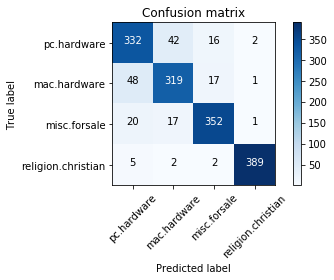

Accuracy for One vs One SVM from LSI:  0.8894568690095846
Precision score for One vs One SVM from LSI:  0.8896523442740364
Recall score for One vs One SVM from LSI:  0.8888653103297756
F-1 score for One vs One SVM from LSI: 0.8891812893554196


In [41]:
# Perform One vs One SVM classification

#reference: https://scikit-learn.org/stable/modules/svm.html (Multiclass Classification)

# ovo = one vs one classifier
clf_ovo = OneVsOneClassifier(LinearSVC(C=10, random_state=42))
# clf_ovo = svm.SVC(kernel='linear', decision_function_shape='ovo')

pipeline_ovo = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', clf_ovo),
],
memory=memory
)

pipeline_ovo.fit(X_train, y_train)

predicted_ovo = pipeline_ovo.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted_ovo), classes=class_names, normalize=False)
plt.savefig('svm-ovo-conf.eps', format='eps', dpi=1000)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display SVM Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for One vs One SVM from LSI: ', pipeline_ovo.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for One vs One SVM from LSI: ', precision_score(y_test, predicted_ovo, average='macro'))
print('Recall score for One vs One SVM from LSI: ', recall_score(y_test, predicted_ovo, average='macro'))
print('F-1 score for One vs One SVM from LSI:', f1_score(y_test, predicted_ovo, average='macro'))

**SVM one vs rest method:**

[Memory]1134.8s, 18.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\ee4e09301fdafe449357940f75c1cbf2
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1134.8s, 18.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\a06b3cf1d324232fe99dbb6066a45630
___________________________________fit_transform_one cache loaded - 0.1s, 0.0min
[Memory]1135.1s, 18.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\01a1ae7f27b46a3b9fc414f20f69c9a3
___________________________________fit_transform_one cache loaded - 0.0s, 0.0min
[Memory]1135.1s, 18.9min: Loading _fit_transform_one from C:\Users\zharr\AppData\Local\Temp\tmpmvx_0hmi\joblib\sklearn\pipeline\_fit_transform_one\4cc43492d141962efbeb36153234500e
___________________________________fi

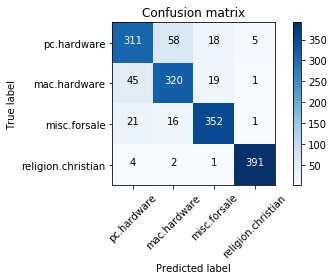

Accuracy for One vs Rest SVM from LSI:  0.8779552715654952
Precision score for One vs Rest SVM from LSI:  0.8773324842064207
Recall score for One vs Rest SVM from LSI:  0.8773780852433042
F-1 score for One vs Rest SVM from LSI: 0.8772738926493574


In [42]:
# ovr: one vs rest
clf_ovr = OneVsRestClassifier(LinearSVC(C=10, random_state=42))

pipeline_ovr = Pipeline([
    ('import', Importer(remove=None)),
    ('vect', CountVectorizer(min_df=3, analyzer=stem_rmv_punc, stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('reduce_dim', TruncatedSVD(random_state=42, n_components=50)),
    ('clf', clf_ovr),
],
memory=memory
)

pipeline_ovr.fit(X_train, y_train)

predicted_ovr = pipeline_ovr.predict(X_test)

# Confusion matrix
from sklearn.metrics import confusion_matrix
class_names = ['pc.hardware', 'mac.hardware', 'misc.forsale', 'religion.christian']
plot_confusion_matrix(confusion_matrix(y_test, predicted_ovr), classes=class_names, normalize=False)
plt.savefig('svm-ovr-conf.eps', format='eps', dpi=1000)
plt.show()
# print('Confusion matrix: \n', confusion_matrix(, predicted))

# Display SVM Stats
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print('Accuracy for One vs Rest SVM from LSI: ', pipeline_ovr.score(X_test, y_test))
# print('Average precision-recall score for Gaussian NB from LSI:', average_precision_score(y_test, predicted))
print('Precision score for One vs Rest SVM from LSI: ', precision_score(y_test, predicted_ovr, average='macro'))
print('Recall score for One vs Rest SVM from LSI: ', recall_score(y_test, predicted_ovr, average='macro'))
print('F-1 score for One vs Rest SVM from LSI:', f1_score(y_test, predicted_ovr, average='macro'))